In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras.layers import Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils.vis_utils import plot_model as pm
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from keras.models import load_model
import keras.backend as K
# Set random seed
np.random.seed(0)

In [0]:
path 			= r'/content/gdrive/My Drive/ML Project/Baseball Faces'
os.chdir(path)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [0]:
# Image PreProcessing
df 						= pd.read_csv('Train.csv')
df['Image_Name'] 		= df['Image_Name'] + '.jpg'


rs =  ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
train_index, test_index = list(rs.split(df))[0]

y_col  					= ['Competency_Score', 'Trustworthy_Score']

In [0]:
df_trn = df.iloc[train_index,:]
df_tst = df.iloc[test_index,:]

batch_size = 32

K.set_image_dim_ordering('th')

dg_subtrn 				= ImgDataGen(rotation_range=20,
                               rescale = 1./255.,
                               validation_split = 0.2,
                               dtype = 'float32')

dg_tst  					= ImgDataGen(rotation_range=20,
                               rescale = 1./255.)

df_subtrn = dg_subtrn.flow_from_dataframe(dataframe = df_trn,\
											directory = "./TrainPictures/",\
											x_col = "Image_Name",\
											y_col = y_col,\
											batch_size = batch_size,\
											seed = 42,\
											shuffle = True,\
											color_mode = "rgb",\
											class_mode = "other",\
											target_size = (85,128),\
											has_ext = False,\
											subset = 'training')


df_val = dg_subtrn.flow_from_dataframe(dataframe = df_trn,\
											directory = "./TrainPictures/",\
											x_col = "Image_Name",\
											y_col= y_col,\
											batch_size = batch_size,\
											seed = 42,\
											shuffle = True,\
											color_mode = "rgb",\
											class_mode = "other",\
											target_size = (85,128),\
											has_ext = False,\
											subset = 'validation')

df_tst = dg_tst.flow_from_dataframe(dataframe = df_tst,\
										directory="./TrainPictures/",\
										x_col="Image_Name",\
										y_col= y_col,\
										batch_size=batch_size,\
										seed=42,\
										shuffle=False,\
										class_mode="other",\
										target_size=(85,128))

Found 512 images.
Found 128 images.
Found 160 images.


## Mixed Model

In [0]:
#-- Model Building

def deep_model(df_subtrn, 
               df_val, 
               df_tst,  
               cnn_type = 'cnn',
               loss='binary_crossentropy', 
               optimizer ='adam',
               learn_rate = 0.05,
               num_epochs=5,
               n_batch_size = 500, 
               verbose = True, 
               model_summary = True, 
               plot = True):

    '''Inputs
    1. cnn_type:        CNN structure to implement ['cnn', 'lenet', 'alexnet']
    2. loss:            See keras documentation for full list of options https://keras.io/losses/
    3. optimizer        See keras https://keras.io/optimizers/
    4. learn_rate:      Learning rate of adagrad optimizer
    4. num_epochs:      Number of epochs to use in training
    5. n_batch_size:    Sample size to use for each node 
    6. verbose:         Print model performance at each epoch [True, False]
    7. model_summary:   Print model summary [True, False]
    8. plot:            If you want to plot the Train/Test accuracy and loss curves
    '''

    # Instantiate Model
    cnn = Sequential()

    # Add Layers
    '''
    input_shape: specifies the dimension of the input to the layer
    activation:  function used to activate the layer
    units:       number of neurons in the layer.  if our output is 1, and we are on the last layer, then units should = 1
    '''


    # Build Model
    '''
    Inspiration for CNN structures: https://www.jeremyjordan.me/convnet-architectures/
    '''

    '''
    Basic CNN
    '''
    if cnn_type == 'cnn':

      cnn.add(Conv2D(filters 		= 32,\
         kernel_size 	= (2, 2),\
         activation 	= 'relu',\
         input_shape 	= (3, 85, 128)))

      cnn.add(MaxPooling2D(pool_size = (2, 2)))

      # Generalizing 
      cnn.add(Dropout(0.25))

      # Flattening
      cnn.add(Flatten())

      # Full Connnection
      cnn.add(Dense(units 		= 128,\
               activation 	= 'relu'))

      cnn.add(Dense(units 		= 2,\
               activation 	= 'linear'))

#LeNet-5: https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

    elif cnn_type == 'lenet':
      
      cnn.add(layers.Conv2D(filters=6, 
                            kernel_size=(3, 3), 
                            activation='relu', 
                            input_shape = (3, 85, 128)))

      cnn.add(layers.AveragePooling2D())
      cnn.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
      cnn.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
      cnn.add(layers.AveragePooling2D())
      cnn.add(layers.Flatten())
      cnn.add(layers.Dense(units=120, activation='relu'))
      cnn.add(layers.Dense(units=84, activation='relu'))
      cnn.add(layers.Dense(units=2, activation = 'linear'))

#AlexNet: https://engmrk.com/alexnet-implementation-using-keras/

    elif cnn_type == 'alexnet':

      # 1st Convolutional Layer
      cnn.add(Conv2D(filters=96, input_shape=(3, 85,128), kernel_size=(3,3), strides=(2,2), padding='valid'))
      cnn.add(Activation('relu'))
      # Max Pooling
      cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

      # 2nd Convolutional Layer
      cnn.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
      cnn.add(Activation('relu'))
      # Max Pooling
      cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

      # 3rd Convolutional Layer
      cnn.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
      cnn.add(Activation('relu'))

      # 4th Convolutional Layer
      cnn.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
      cnn.add(Activation('relu'))

      # 5th Convolutional Layer
      cnn.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
      cnn.add(Activation('relu'))
      # Max Pooling
      cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

      # Passing it to a Fully Connected layer
      cnn.add(Flatten())
      # 1st Fully Connected Layer
      cnn.add(Dense(4096, input_shape=(85*128*3,)))
      cnn.add(Activation('relu'))
      # Add Dropout to prevent overfitting
      cnn.add(Dropout(0.4))

      # 2nd Fully Connected Layer
      cnn.add(Dense(4096))
      cnn.add(Activation('relu'))
      # Add Dropout
      cnn.add(Dropout(0.4))

      # 3rd Fully Connected Layer
      cnn.add(Dense(1000))
      cnn.add(Activation('relu'))
      # Add Dropout
      cnn.add(Dropout(0.4))

      # Output Layer
      cnn.add(Dense(2))
      cnn.add(Activation('linear'))

    # Specify Optomizer
    if optimizer == 'adagrad':
      optim = keras.optimizers.Adagrad(lr=learn_rate, epsilon=None, decay=0.0001)
    else:
      optim = optimizer


    cnn.compile(loss=loss, 
                optimizer=optim, 
                metrics=['mae', 'accuracy'])
    
    #Setting Up Callbacks
    callbacks = [#EarlyStopping(monitor='val_acc'),  
             ModelCheckpoint(filepath='best_model_'+cnn_type+'.h5', 
                             monitor='val_mean_absolute_error', 
                             save_best_only=True, 
                             mode = 'min')]

    # Prints Summary of NN Structure
    if model_summary == True:
        cnn.summary()

    # Set Number of Epochs

    history = cnn.fit_generator(df_subtrn,
                                epochs = num_epochs,
                                steps_per_epoch= df_subtrn.samples // batch_size, 
                                verbose= verbose, 
                                validation_data=df_val,
                                validation_steps=df_val.samples // n_batch_size,
                                callbacks = callbacks)

    # Measure Accuracy of Model
    train_loss, train_mae, train_accuracy = cnn.evaluate_generator(df_subtrn, steps= len(df_subtrn))
    print('Training MAE: {}'.format(round(train_accuracy,4)))
    test_loss, test_mae, test_accuracy = cnn.evaluate_generator(df_tst, steps= len(df_tst))
    print('Test MAE: {}'.format(round(test_accuracy, 4)))
    
    if plot == True:
      plt.style.use('ggplot')
      plot_history(history, testMetric=test_accuracy, met = 'acc')
      plt.show()
      plot_history(history, testMetric=test_mae, met = 'mean_absolute_error')
      plt.show()
    
    return cnn

def plot_history(history, testMetric, met = 'acc'):
  metric = history.history[met]
  val_metric = history.history['val_'+met]

  fig = plt.gcf()
  fig.set_size_inches(11, 8)
  fig.show()
  plt.plot(history.history[met])
  plt.plot(history.history['val_'+met])
  plt.axhline(y=testMetric, color='r', linestyle='--')
  # -- -- -- --
  plt.title('model '+met)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation','test score'], loc='upper left')
  # End Of Function---------------------------------

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 42, 63)        2688      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 42, 63)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 21, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 19, 29)       221440    
_________________________________________________________________
activation_2 (Activation)    (None, 256, 19, 29)       0         
_________________________________________________________________
max_pooling2d_2 (MaxP

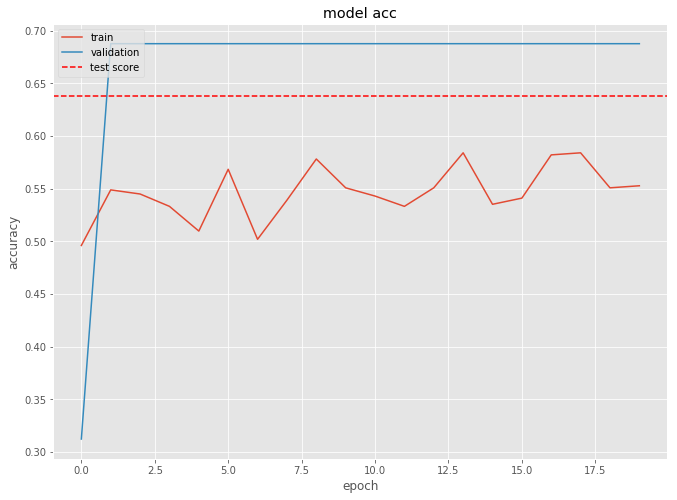

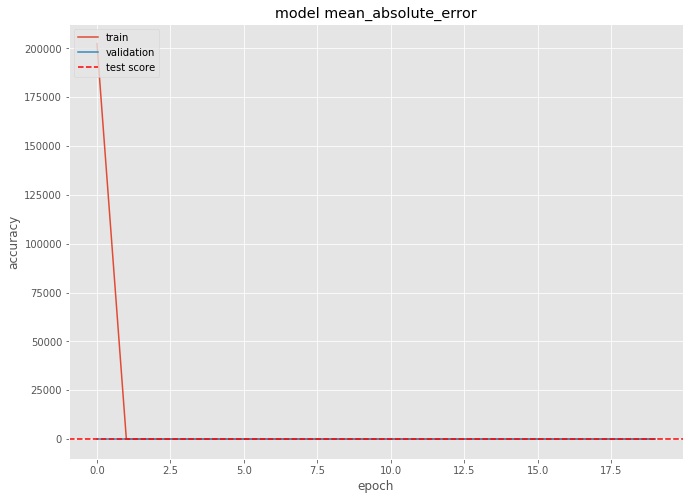

In [0]:
deep_model(df_subtrn, 
           df_val,
           df_tst,
           num_epochs = 20,
           cnn_type = 'alexnet',
           loss='mean_squared_error', 
           optimizer ='adagrad',
           learn_rate = 0.01,
           n_batch_size = 32, 
           verbose = True, 
           model_summary = True, 
           plot = True)

In [0]:
#-- Load Best Model (CNN)
best_model = load_model('best_model_cnn.h5')

pred = best_model.predict_generator(df_tst, steps= len(df_tst), verbose=1)
print(pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
5/5 [==============================] - 2s 400ms/step
1.5496246814727783
